<a href="https://colab.research.google.com/github/MasterScrat/droneRL-workshop/blob/fast/01_Intro_to_environment_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Setup
---

Make sure to select `GPU` under Runtime > Change runtime type > Hardware accelerator!

In [ ]:
import sys

# Setup for use in Colab
if 'google.colab' in sys.modules:
    # Clone GitHub repository
    !rm -rf /content/droneRL-workshop
    !git clone https://github.com/MasterScrat/droneRL-workshop.git --branch fast --single-branch

    # Install packages via pip
    !pip install -r "droneRL-workshop/requirements.txt"

    # Restart Runtime so everything takes effect
    import os
    os.kill(os.getpid(), 9)

    # Your Runtime will crash after this - this is normal!

Cloning into 'droneRL-workshop'...
remote: Enumerating objects: 689, done.
remote: Counting objects: 100% (146/146), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 689 (delta 76), reused 139 (delta 73), pack-reused 543 (from 1)
Receiving objects: 100% (689/689), 22.61 MiB | 16.31 MiB/s, done.
Resolving deltas: 100% (402/402), done.


In [1]:
%cd /content/droneRL-workshop

/content/droneRL-workshop


In [2]:
%matplotlib inline
import os
from PIL import Image
from IPython.lib.pretty import pretty

The challenge environment
---

The environment for this challenge is called **`DeliveryDrones`**.

After creating the environment, call `reset()` to initalize the environment.

In [3]:
from env.env import DeliveryDrones

# Create environment
env = DeliveryDrones()

# Resets it and get the initial observation
observation = env.reset()

# Render in text
print(env.render(mode='ansi'))

+---+---+---+---+---+---+---+---+
|   |   |[ ]| # |   |[ ]| # | x |
+---+---+---+---+---+---+---+---+
|   |   |   |   |   |   |   | x |
+---+---+---+---+---+---+---+---+
|   |   | 2 |   | x |   |[ ]|   |
+---+---+---+---+---+---+---+---+
|   | 0 |   |   |   | # |   | @ |
+---+---+---+---+---+---+---+---+
| @ |   |   | x |   | # | # | @ |
+---+---+---+---+---+---+---+---+
|[ ]|   | # |   | # | # | x | x |
+---+---+---+---+---+---+---+---+
|   | x |   | x | x |[1]|   |   |
+---+---+---+---+---+---+---+---+
| @ |[ ]| @ | @ | # |   |   |   |
+---+---+---+---+---+---+---+---+


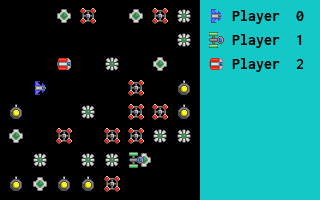

In [4]:
# Render as an RGB image to see things more clearly
Image.fromarray(env.render(mode='rgb_array'))

Observations spaces
---

By default, the environment returns `ground` and `air` grids as observations.

In [5]:
# Observations are returned after env.reset() or env.step() calls
print(observation)

{'ground': <env.env.Grid object at 0x7b53528e7040>, 'air': <env.env.Grid object at 0x7b53528e7b20>}


In [6]:
# We can inspect what's on the ground
observation['ground'].grid

array([[None, None, Z, #, None, Z, #, P],
       [None, None, None, None, None, None, None, P],
       [None, None, None, None, P, None, Z, None],
       [None, None, None, None, None, #, None, @],
       [@, None, None, P, None, #, #, @],
       [Z, None, #, None, #, #, P, P],
       [None, P, None, P, P, Z, None, None],
       [@, Z, @, @, #, None, None, None]], dtype=object)

We use **observation wrappers** to produce states that can be used with RL agents.

{2: 6, 1: 5, 0: 7}


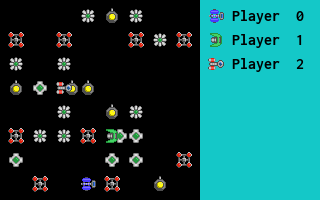

In [7]:
from env.wrappers import CompassQTable, CompassChargeQTable, LidarCompassQTable, LidarCompassChargeQTable

# Create the environment
env = DeliveryDrones()

# Use an observation wrappers
env = CompassQTable(env)

# Reset the environment and print inital observation
observation, info = env.reset()
print(pretty(observation))

# Render as an RGB image
Image.fromarray(env.render(mode='rgb_array'))

In [8]:
# Print the state in a nicer way using `env.format_state`
{drone: env.format_state(observation) for drone, observation in observation.items()}

{2: '↑', 1: '↗', 0: '↖'}

In [9]:
from env.env import Action

Action??

Rewards: {0: 0, 2: -0.1}


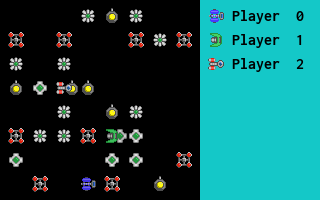

In [10]:
observation, reward, done, truncated, info = env.step({0: Action.STAY})

print('Rewards: {}'.format(reward))
Image.fromarray(env.render(mode='rgb_array'))

In [11]:
{drone: env.format_state(observation) for drone, observation in observation.items()}

{2: '↑', 1: '↗', 0: '↖'}

The `WindowedGridView` observation wrapper
---

This is the "official" wrapper for the competition!

```
Observation wrapper: (N, N, 6) numerical arrays with location of
(0) drones         marked with                   1 / 0 otherwise
(1) packets        marked with                   1 / 0 otherwise
(2) dropzones      marked with                   1 / 0 otherwise
(3) stations       marked with                   1 / 0 otherwise
(4) drones charge  marked with   charge level 0..1 / 0 otherwise
(5) obstacles      marked with                   1 / 0 otherwise
Where N is the size of the window, i the number of drones
```

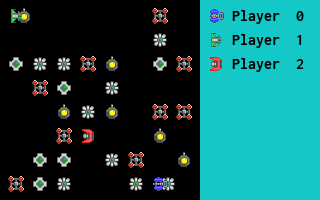

In [12]:
from env.wrappers import WindowedGridView

env = WindowedGridView(DeliveryDrones(), radius=2)
states, info = env.reset()
Image.fromarray(env.render(mode='rgb_array'))

In [13]:
{drone: env.format_state(state) for drone, state in states.items()}

{1: 'Numpy array (5, 5, 6)',
 2: 'Numpy array (5, 5, 6)',
 0: 'Numpy array (5, 5, 6)'}

In [14]:
states[0][:, :, 5] # Obstacles from the perspective of drone 0

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1.]])

Create and run agents
---

After creating your agents, you can run them with the `test_agents()` method

In [15]:
from agents.random import RandomAgent

# Create and setup the environment
env = WindowedGridView(DeliveryDrones(), radius=3)
states, info = env.reset()

# Create random agents
agents = {drone.index: RandomAgent(env) for drone in env.drones}
agents

{0: <agents.random.RandomAgent at 0x7b53283d40d0>,
 1: <agents.random.RandomAgent at 0x7b53283d6650>,
 2: <agents.random.RandomAgent at 0x7b53283d6da0>}

In [16]:
# The random agents just pick an action randomly
RandomAgent??

In [17]:
from helpers.rl_helpers import test_agents

# Run agents for 1000 steps
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)

# Print rewards
for drone_index, rewards in rewards_log.items():
    print('Drone {} rewards: {} ..'.format(drone_index, rewards[:10]))

Testing agents: 100%|██████████| 1000/1000 [00:00<00:00, 1686.09it/s]

Drone 0 rewards: [0, -1, 0, 0, 0, -0.1, 0, 0, -1, -0.1] ..
Drone 1 rewards: [-1, 0, 0, 0, -1, 0, 0, 0, 0, 0] ..
Drone 2 rewards: [-1, 0, -1, 0, 0, 0, -0.1, 0, -0.1, 0] ..


And visualize the rewards with the helpers functions

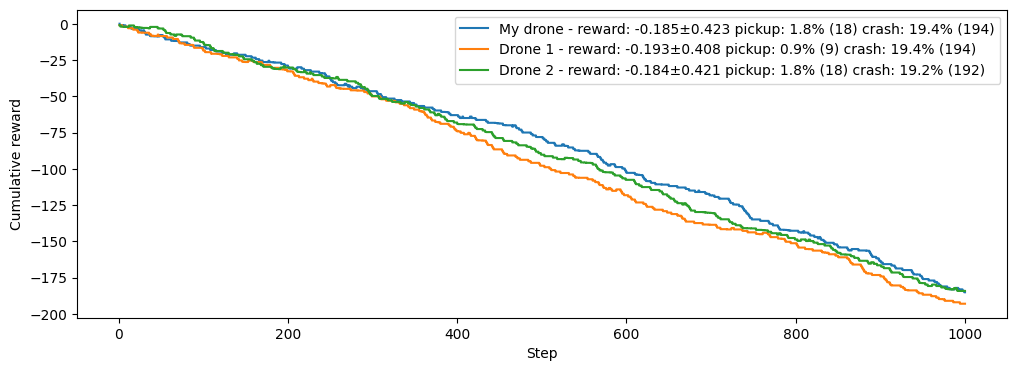

In [18]:
from helpers.rl_helpers import plot_cumulative_rewards

plot_cumulative_rewards(
    rewards_log,
    events={'pickup': [1], 'crash': [-1]}, # Optional, default: pickup/crash ±1
    drones_labels={0: 'My drone'}, # Optional, default: drone index
)

Train a first agent
---

To train your agents, you will use the `MultiAgentTrainer()`

In [19]:
from agents.dqn import DQNAgent, DenseQNetworkFactory
from helpers.rl_helpers import MultiAgentTrainer, plot_rolling_rewards

# Create and setup the environment
env = WindowedGridView(DeliveryDrones(), radius=3)
env.env_params.update({'n_drones': 3, 'skyscrapers_factor': 0, 'charge_reward': 0, 'discharge': 0})
states = env.reset()

# Create random agents
agents = {drone.index: RandomAgent(env) for drone in env.drones}

# Use a DQNAgent for agent 0 - we will see how this works next
agents[0] = DQNAgent(
    env, DenseQNetworkFactory(env, hidden_layers=[32, 32]),
    gamma=0.95, epsilon_start=1.0, epsilon_decay=0.999, epsilon_end=0.01,
    memory_size=10000, batch_size=64, target_update_interval=5
)

agents

cuda


{0: <agents.dqn.DQNAgent at 0x7b527f51aa70>,
 1: <agents.random.RandomAgent at 0x7b527f51aa40>,
 2: <agents.random.RandomAgent at 0x7b527f518370>}

In [20]:
# Create trainer
trainer = MultiAgentTrainer(env, agents, reset_agents=True, seed=0)

# Train with different grids
trainer.train(1000)

# Print rewards
for drone_index, rewards in trainer.rewards_log.items():
    print('Drone {} rewards: {} ..'.format(drone_index, rewards[:10]))

DenseQNetwork(
  (network): Sequential(
    (dense_1): Linear(in_features=294, out_features=32, bias=True)
    (dense_act_1): ReLU()
    (dense_2): Linear(in_features=32, out_features=32, bias=True)
    (dense_act_2): ReLU()
    (dense_3): Linear(in_features=32, out_features=5, bias=True)
  )
)
DenseQNetwork(
  (network): Sequential(
    (dense_1): Linear(in_features=294, out_features=32, bias=True)
    (dense_act_1): ReLU()
    (dense_2): Linear(in_features=32, out_features=32, bias=True)
    (dense_act_2): ReLU()
    (dense_3): Linear(in_features=32, out_features=5, bias=True)
  )
)


Training agents: 100%|██████████| 1000/1000 [00:04<00:00, 209.39it/s]

Drone 0 rewards: [0, 0, 0, 0, 0, 0, 0, 0, 1, 0] ..
Drone 1 rewards: [0, 0, 0, 0, -1, -1, 0, 0, 0, -1] ..
Drone 2 rewards: [0, 0, -1, 0, 0, -1, 0, 0, 0, 0] ..


And visualize training with helpers functions

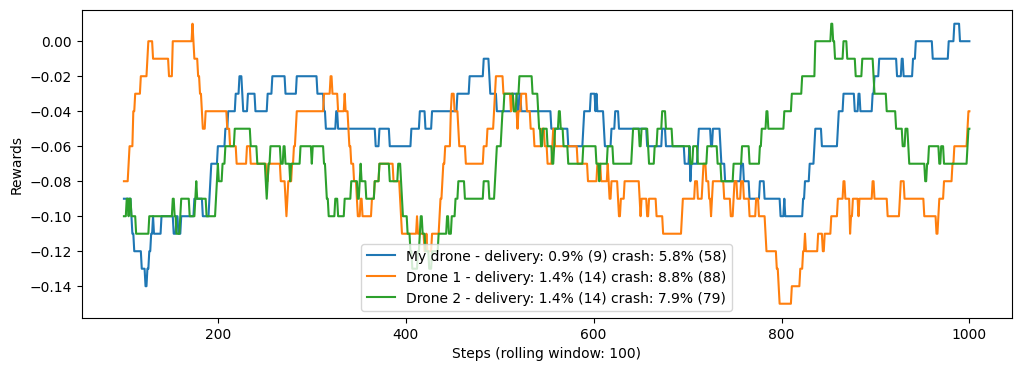

In [21]:
plot_rolling_rewards(
    trainer.rewards_log,
    drones_labels={0: 'My drone'}, # Optional: specify drone names
)

Test agents
---

Testing agents: 100%|██████████| 1000/1000 [00:01<00:00, 918.14it/s]


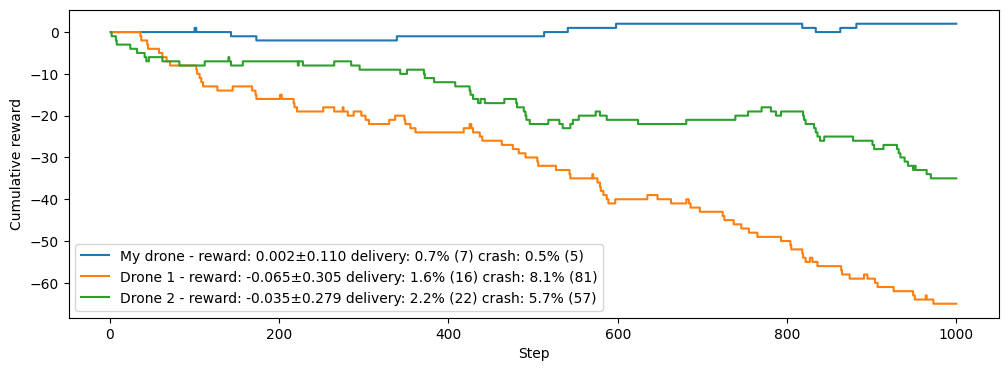

In [22]:
rewards_log = test_agents(env, agents, n_steps=1000, seed=0)
plot_cumulative_rewards(rewards_log, drones_labels={0: 'My drone'})

Visualize a "run"
---

Share videos of your best agents! `#AMLD2024` `#droneRL`

In [23]:
from helpers.rl_helpers import render_video, ColabVideo

path = os.path.join('output', 'videos', 'intro-run.mp4')
render_video(env, agents, video_path=path, n_steps=120, fps=1, seed=None)

Running agents: 100%|██████████| 120/120 [00:00<00:00, 514.21frame/s]


Moviepy - Building video output/videos/intro-run.mp4.
Moviepy - Writing video output/videos/intro-run.mp4



Moviepy - Done !
Moviepy - video ready output/videos/intro-run.mp4


In [24]:
ColabVideo(path)

## Submit to AIcrowd! 🚀

In [25]:
path = os.path.join('output', 'agents', 'first-agent.pt')
agents[0].save(path)

Download the file `output/agents/first-agent.pt` and submit it:

https://www.aicrowd.com/challenges/dronerl